In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import random
from tqdm import tqdm

# print directory
import os
print(os.getcwd())
os.chdir("../..")
print(os.getcwd())

#from src.models.sparse_autoencoder import *
from src.functions.sae_training import *
#from src.functions.sae_analysis_sim import *
from src.functions.sae_analysis_sim2 import *
from src.models.autoencoder import *
from src.visualization.plotting import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set a random seed
seed = 0

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

data_dir = '/projects/heads/data/simulation/singlecell/'

/home/dbm829/projects/interpreting_omics_models/02_experiments/simulation
/home/dbm829/projects/interpreting_omics_models


In [2]:
complexity = 'high'
n_samples = 10000
latent_dim = 150
model_depth = 2
dropout_rate = 0.1

for seed in range(10):
    temp_y = torch.load(data_dir+'large_{}-complexity_rs{}_y.pt'.format(complexity, seed), weights_only=False)
    temp_x0 = torch.load(data_dir+'large_{}-complexity_rs{}_x0.pt'.format(complexity, seed), weights_only=False)
    temp_x1 = torch.load(data_dir+'large_{}-complexity_rs{}_x1.pt'.format(complexity, seed), weights_only=False)
    temp_x2 = torch.load(data_dir+'large_{}-complexity_rs{}_x2.pt'.format(complexity, seed), weights_only=False)
    temp_ct = torch.load(data_dir+'large_{}-complexity_rs{}_ct.pt'.format(complexity, seed), weights_only=False)
    temp_cov = torch.load(data_dir+'large_{}-complexity_rs{}_co.pt'.format(complexity, seed), weights_only=False)
    if seed == 0:
        rna_counts = temp_y
        x0 = temp_x0
        x1 = temp_x1
        x2 = temp_x2
        ct = temp_ct
        co = temp_cov
    else:
        rna_counts = torch.cat((rna_counts, temp_y), dim=0)
        x0 = torch.cat((x0, temp_x0), dim=0)
        x1 = torch.cat((x1, temp_x1), dim=0)
        x2 = torch.cat((x2, temp_x2), dim=0)
        ct = torch.cat((ct, temp_ct), dim=0)
        co = torch.cat((co, temp_cov), dim=0)
# limit to the training data
n_samples_validation = int(n_samples*0.1)
rna_counts = rna_counts[-n_samples_validation:]
x0 = x0[-n_samples_validation:]
x1 = x1[-n_samples_validation:]
x2 = x2[-n_samples_validation:]
ct = ct[-n_samples_validation:]
co = co[-n_samples_validation:]

In [3]:
use_y = True

if use_y:
    comparison_data = np.concatenate((rna_counts.cpu().detach().numpy(), x0.cpu().detach().numpy(), x1.cpu().detach().numpy(), x2.cpu().detach().numpy(), ct.unsqueeze(1).cpu().detach().numpy(), co.unsqueeze(1).cpu().detach().numpy()), axis=1).T
    coeff_names = ['y']*rna_counts.shape[1] + ['x0']*x0.shape[1] + ['x1']*x1.shape[1] + ['x2']*x2.shape[1] + ['ct'] + ['co']
else:
    comparison_data = np.concatenate((x0.cpu().detach().numpy(), x1.cpu().detach().numpy(), x2.cpu().detach().numpy(), ct.unsqueeze(1).cpu().detach().numpy(), co.unsqueeze(1).cpu().detach().numpy()), axis=1).T
    coeff_names = ['x0']*x0.shape[1] + ['x1']*x1.shape[1] + ['x2']*x2.shape[1] + ['ct'] + ['co']

print(comparison_data.shape)

(20302, 1000)


In [4]:
latent_dim = 150

# load encoder

#encoder = Encoder(20000, latent_dim, model_depth).to(device)
model_name = 'large_high-complexity_2-depth_{}-latent_0.1-dropout_100000-samples'.format(latent_dim)
encoder = torch.load('03_results/models/sim2_{}_encoder.pth'.format(model_name)).cpu()

encoder.eval()
reps = encoder(rna_counts).detach()

input_size = latent_dim
batch_size = 128
train_data = reps.clone().to(device)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

/tmp/ipykernel_1795486/3388184713.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load('03_results/models/sim2_{}_encoder.pth'.format(model_name)).cpu()


In [5]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)
# adjacency matrices (binary)
p_xy = 0.1
xy = torch.tensor(np.random.binomial(1, p_xy, (100, 20000))).float()

# SAE 1000x

In [ ]:
if not os.path.exists(data_dir+'sim2_{}_sae1000x_activations.pth'.format(model_name)):
    sae_model, loss = train_sae(
        train_loader,
        input_size=input_size,
        hidden_factor=1000,
        lr=1e-6,
        l1_weight=1e-2,
        n_epochs=5000,
        sae_type='bricken',
        return_all_losses=True,
        print_progress=True,
    )

    reps_reconstructed, activations = sae_model(reps.to(device))

    # save activations
    torch.save(activations, data_dir+'sim2_{}_sae1000x_activations.pth'.format(model_name))
    # also save the model
    torch.save(sae_model, data_dir+'sim2_{}_sae1000x_model.pth'.format(model_name))
else:
    activations = torch.load(data_dir+'sim2_{}_sae1000x_activations.pth'.format(model_name))
    sae_model = torch.load(data_dir+'sim2_{}_sae1000x_model.pth'.format(model_name))

/tmp/ipykernel_1795486/4032398139.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  activations = torch.load(data_dir+'sim2_{}_sae1000x_activations.pth'.format(model_name

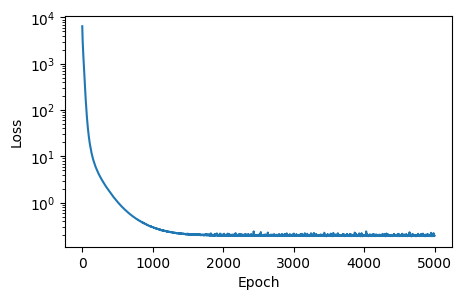

In [8]:
# plot the losses
fig, ax = plt.subplots(1, 1, figsize=(5,3))
sns.lineplot(x=range(len(loss)), y=loss, ax=ax)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.yscale('log')
plt.show()

## cosine similarity and other important metrics

In [7]:
comparison_data = torch.tensor(comparison_data).float()
activations = activations.cpu().detach()

if os.path.exists(data_dir+'sim2_{}_sae1000x_cos_sim_data-activations.pth'.format(model_name)):
    cos_sim = torch.load(data_dir+'sim2_{}_sae1000x_cos_sim_data-activations.pth'.format(model_name))
else:
    cos_sim = torch.zeros((comparison_data.shape[0], activations.shape[1]))
    for i in tqdm(range(comparison_data.shape[0])):
        cos_sim[i,:] = torch.nn.functional.cosine_similarity(activations, comparison_data[i,:].unsqueeze(1), dim=0).detach().cpu()
    torch.save(cos_sim, data_dir+'sim2_{}_sae1000x_cos_sim_data-activations.pth'.format(model_name))

/tmp/ipykernel_1776775/3459944309.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cos_sim = torch.load(data_dir+'sim2_{}_sae1000x_cos_sim_data-activations.pth'.format(mo

In [8]:
comparison_data = torch.tensor(comparison_data).float()
activations = activations.cpu().detach()

cos_sim = torch.zeros((comparison_data.shape[0], activations.shape[1]))
for i in tqdm(range(comparison_data.shape[0])):
    cos_sim[i,:] = torch.nn.functional.cosine_similarity(activations, comparison_data[i,:].unsqueeze(1), dim=0).detach().cpu()
torch.save(cos_sim, data_dir+'sim2_{}_sae1000x_cos_sim_data-activations.pth'.format(model_name))

100%|██████████| 20302/20302 [43:09<00:00,  7.84it/s]


In [28]:
# threshold is 5th percentile of the activations
# sample from the activations
threshold = torch.quantile(torch.randperm(activations.shape[0])[:1000].flatten().float(), 0.05).item()
print('Threshold:', threshold)

unique_active_indices = get_unique_active_unit_indices_from_activations(activations, threshold=threshold)
print('Number of unique active units:', len(unique_active_indices))

# get the maximum cosine similarity for each active feature, as well as the index
# there is no function for this
max_cos_sim = torch.zeros((len(unique_active_indices), 2))
for i, idx in enumerate(unique_active_indices):
    max_cos_sim[i,0] = torch.max(cos_sim[:,idx]).item()
    max_cos_sim[i,1] = torch.argmax(cos_sim[:,idx]).item()

Threshold: 49.95000076293945
Number of unique active units: 131875


In [21]:
activations.mean(0).shape

torch.Size([150000])

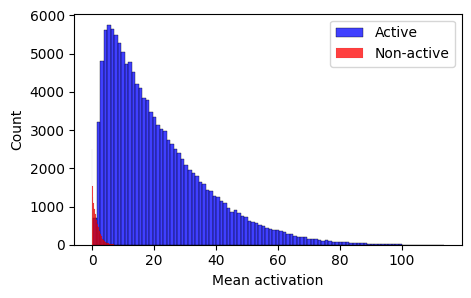

In [22]:
# plot the mean activation colored by non-active and active features
fig, ax = plt.subplots(1, 1, figsize=(5,3))
sns.histplot(activations[:,unique_active_indices].mean(dim=0), bins=100, color='blue', label='Active')
sns.histplot(activations[:,[i for i in range(activations.shape[1]) if i not in unique_active_indices]].mean(dim=0), bins=100, color='red', label='Non-active')
plt.xlabel('Mean activation')
plt.ylabel('Count')
plt.legend()
plt.show()

In [15]:
sae_feature_for_y = []
for i in range(rna_counts.shape[1]):
    sae_feature_for_y.append(torch.argmax(cos_sim[i,:]).item())
print('Number of y-specific SAE features:', len(set(sae_feature_for_y)))

non_y_sae_features = list(set(unique_active_indices) - set(sae_feature_for_y))
print('Number of non-y-specific SAE features:', len(non_y_sae_features))

Number of y-specific SAE features: 4872
Number of non-y-specific SAE features: 127003


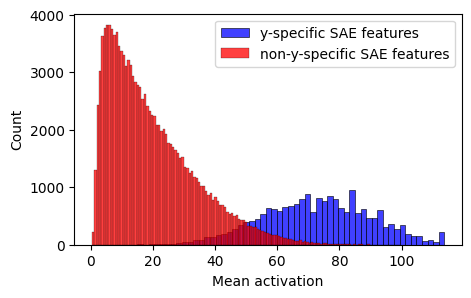

In [24]:
# plot the mean activation colored by y and non-y features
fig, ax = plt.subplots(1, 1, figsize=(5,3))
sns.histplot(activations[:,sae_feature_for_y].mean(dim=0), color='blue', ax=ax, label='y-specific SAE features')
sns.histplot(activations[:,non_y_sae_features].mean(dim=0), color='red', ax=ax, label='non-y-specific SAE features')
plt.xlabel('Mean activation')
plt.ylabel('Count')
plt.legend()
plt.show()

In [16]:
sae_feature_for_x2 = []
for i in range(20200,20300):
    sae_feature_for_x2.append(non_y_sae_features[torch.argmax(cos_sim[i,non_y_sae_features]).item()])
print('Number of x2-specific SAE features:', len(set(sae_feature_for_x2)))

Number of x2-specific SAE features: 100


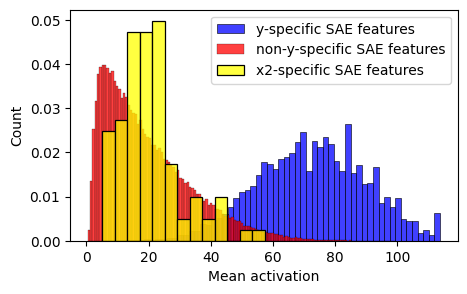

In [28]:
# plot the mean activation colored by y and non-y features
fig, ax = plt.subplots(1, 1, figsize=(5,3))
sns.histplot(activations[:,sae_feature_for_y].mean(dim=0), color='blue', ax=ax, label='y-specific SAE features', stat='density')
sns.histplot(activations[:,non_y_sae_features].mean(dim=0), color='red', ax=ax, label='non-y-specific SAE features', stat='density')
sns.histplot(activations[:,sae_feature_for_x2].mean(dim=0), color='yellow', ax=ax, label='x2-specific SAE features', stat='density')
plt.xlabel('Mean activation')
plt.ylabel('Count')
plt.legend()
plt.show()

In [ ]:
# this is done in script

if not os.path.exists(data_dir+'sim2_{}_sae1000x_sae-cos-sim.pth'.format(model_name)):
    # here all against all
    cos_sim_sae = torch.zeros((len(unique_active_indices), len(unique_active_indices)))
    for i in tqdm(unique_active_indices):
        cos_sim_sae[i,:] = torch.nn.functional.cosine_similarity(activations[:,unique_active_indices], activations[:,i].unsqueeze(1), dim=0).detach().cpu()
    torch.save(cos_sim_sae, data_dir+'sim2_{}_sae1000x_sae-cos-sim.pth'.format(model_name))
else:
    cos_sim_sae = torch.load(data_dir+'sim2_{}_sae1000x_sae-cos-sim.pth'.format(model_name))

 10%|▉         | 13070/131781 [31:06<4:42:34,  7.00it/s]


KeyboardInterrupt: 

In [25]:
thresholds = []
for q in tqdm(np.linspace(0.1, 0.9, 9)):
    thresholds.append(torch.quantile(cos_sim[torch.randint(0, 2000, (100,)),:][:,unique_active_indices].flatten(), q).item())
print(np.linspace(0.1, 0.9, 9))
print(thresholds)

100%|██████████| 9/9 [00:16<00:00,  1.81s/it]

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0.31316038966178894, 0.38886624574661255, 0.44304507970809937, 0.4824061393737793, 0.5388745069503784, 0.5789719820022583, 0.6240221261978149, 0.6768262386322021, 0.7404317855834961]


  0%|          | 0/9 [00:00<?, ?it/s]

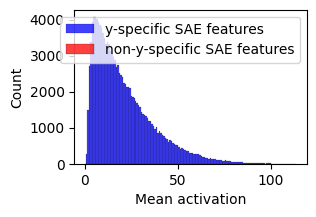

 11%|█         | 1/9 [00:01<00:15,  1.94s/it]

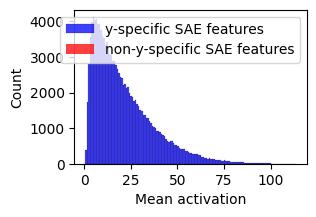

 22%|██▏       | 2/9 [00:04<00:14,  2.08s/it]

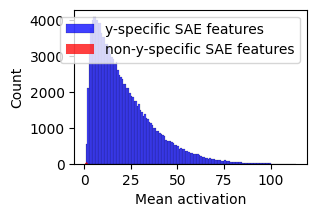

 33%|███▎      | 3/9 [00:06<00:12,  2.06s/it]

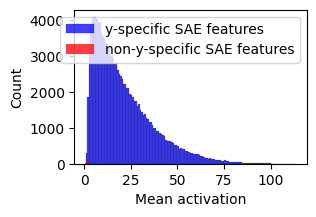

 44%|████▍     | 4/9 [00:08<00:10,  2.01s/it]

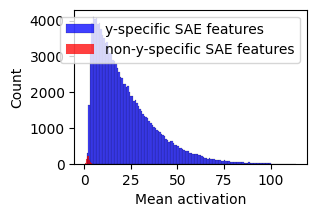

 56%|█████▌    | 5/9 [00:10<00:08,  2.00s/it]

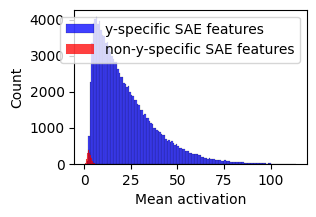

 67%|██████▋   | 6/9 [00:12<00:05,  1.99s/it]

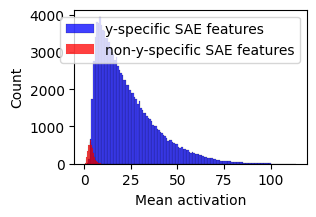

 78%|███████▊  | 7/9 [00:14<00:03,  2.00s/it]

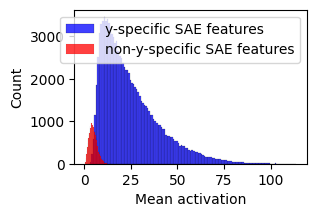

 89%|████████▉ | 8/9 [00:16<00:02,  2.07s/it]

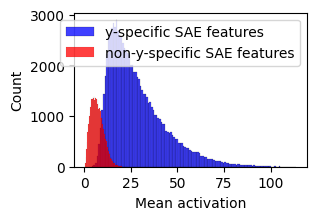

100%|██████████| 9/9 [00:18<00:00,  2.03s/it]


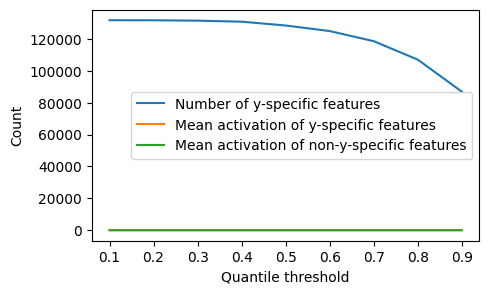

In [28]:
# how could I make a cut between observable sae features and non-observable sae features?
# go through quantiles of cosine sims between y and sae features

n_y_features_temp = []
mean_activation_y_temp = []
mean_activation_non_y_temp = []

for threshold in tqdm(thresholds):
    y_features_temp = (cos_sim[:20000,:][:,unique_active_indices] > threshold).sum(0) > 0
    n_y_features_temp.append(y_features_temp.sum().item())
    mean_activation_y_temp.append(activations[:,unique_active_indices][:,y_features_temp].mean().item())
    mean_activation_non_y_temp.append(activations[:,unique_active_indices][:,~y_features_temp].mean().item())
    # plot a small histogram
    fig, ax = plt.subplots(1, 1, figsize=(3,2))
    sns.histplot(activations[:,unique_active_indices][:,y_features_temp].mean(dim=0), color='blue', ax=ax, label='y-specific SAE features')
    sns.histplot(activations[:,unique_active_indices][:,~y_features_temp].mean(dim=0), color='red', ax=ax, label='non-y-specific SAE features')
    plt.xlabel('Mean activation')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5,3))
sns.lineplot(x=np.linspace(0.1, 0.9, 9), y=n_y_features_temp, ax=ax, label='Number of y-specific features')
sns.lineplot(x=np.linspace(0.1, 0.9, 9), y=mean_activation_y_temp, ax=ax, label='Mean activation of y-specific features')
sns.lineplot(x=np.linspace(0.1, 0.9, 9), y=mean_activation_non_y_temp, ax=ax, label='Mean activation of non-y-specific features')
plt.xlabel('Quantile threshold')
plt.ylabel('Count')
plt.legend()
plt.show()

## plots

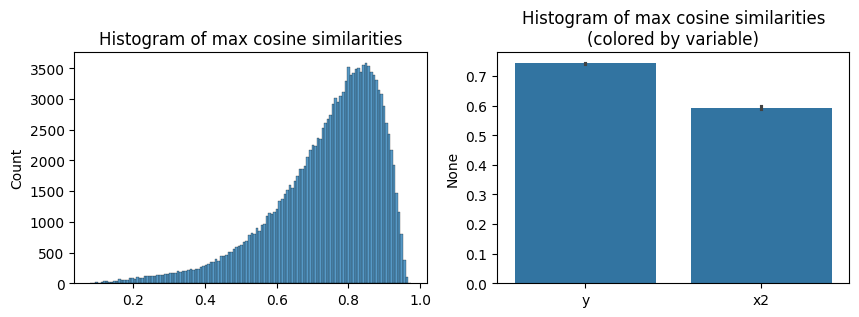

In [15]:
# plot the histogram of max_cos_sim
fig, ax = plt.subplots(1, 2, figsize=(10,3))
sns.histplot(max_cos_sim[:,0], ax=ax[0])
ax[0].set_title('Histogram of max cosine similarities')
# also plot this colored by the coeff_names
variable_colors = [coeff_names[int(x)] for x in max_cos_sim[:,1]]
sns.barplot(x=variable_colors, y=max_cos_sim[:,0], ax=ax[1])
ax[1].set_title('Histogram of max cosine similarities\n(colored by variable)')
plt.show()

### visual inspection

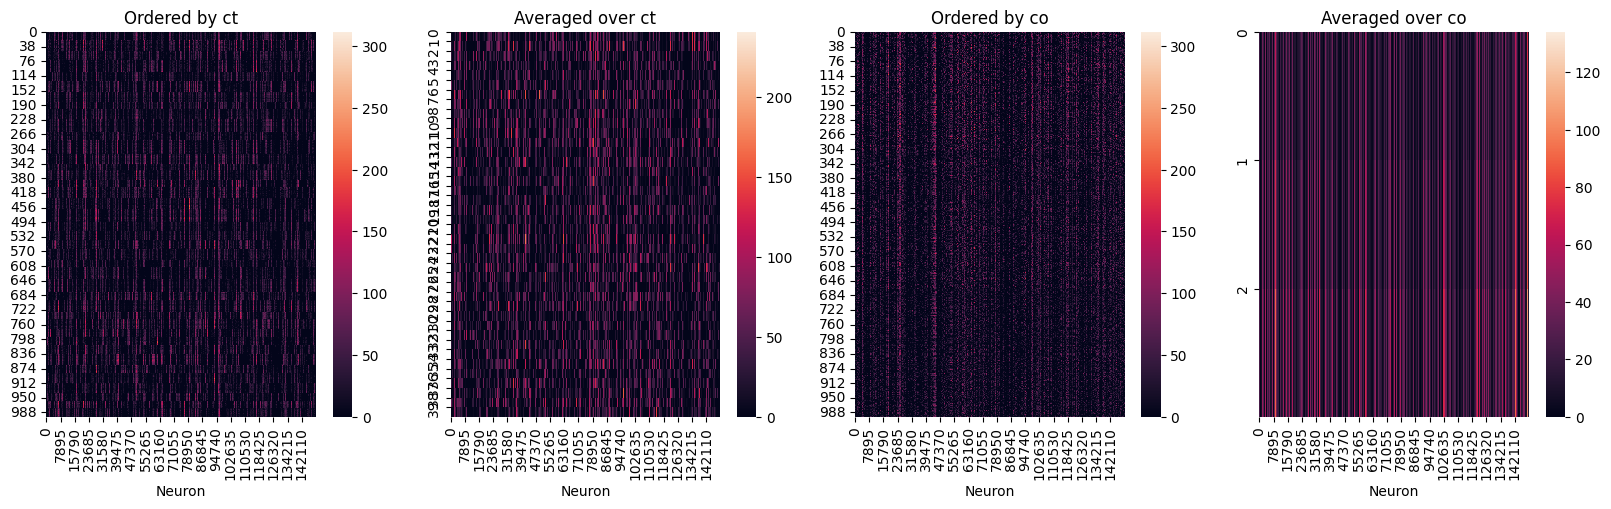

In [16]:
# order samples by ct and co and plot again

ct_order = torch.argsort(ct, descending=True)
co_order = torch.argsort(co, descending=True)

fig, ax = plt.subplots(1, 4, figsize=(20,5))
sns.heatmap(activations[ct_order,:].cpu().detach().numpy(), ax=ax[0])
ax[0].set_xlabel('Neuron')
ax[0].set_title('Ordered by ct')
# on the other size plot them averaged over ct
ct_mean_activations = torch.zeros((ct.unique().shape[0], activations.shape[1]))
for i, ct_val in enumerate(ct.unique()):
    ct_mean_activations[i,:] = activations[ct == ct_val,:].mean(axis=0)
sns.heatmap(ct_mean_activations.cpu().detach().numpy(), ax=ax[1])
ax[1].set_yticks(range(ct.unique().shape[0]))
ax[1].set_yticklabels(ct.unique().numpy())
ax[1].set_xlabel('Neuron')
ax[1].set_title('Averaged over ct')

sns.heatmap(activations[co_order,:].cpu().detach().numpy(), ax=ax[2])
ax[2].set_xlabel('Neuron')
ax[2].set_title('Ordered by co')
# on the other size plot them averaged over co
co_mean_activations = torch.zeros((co.unique().shape[0], activations.shape[1]))
for i, co_val in enumerate(co.unique()):
    co_mean_activations[i,:] = activations[co == co_val,:].mean(axis=0)
sns.heatmap(co_mean_activations.cpu().detach().numpy(), ax=ax[3])
ax[3].set_yticks(range(co.unique().shape[0]))
ax[3].set_yticklabels(co.unique().numpy())
ax[3].set_xlabel('Neuron')
ax[3].set_title('Averaged over co')
plt.show()


Number of non-y-specific SAE features: 144273


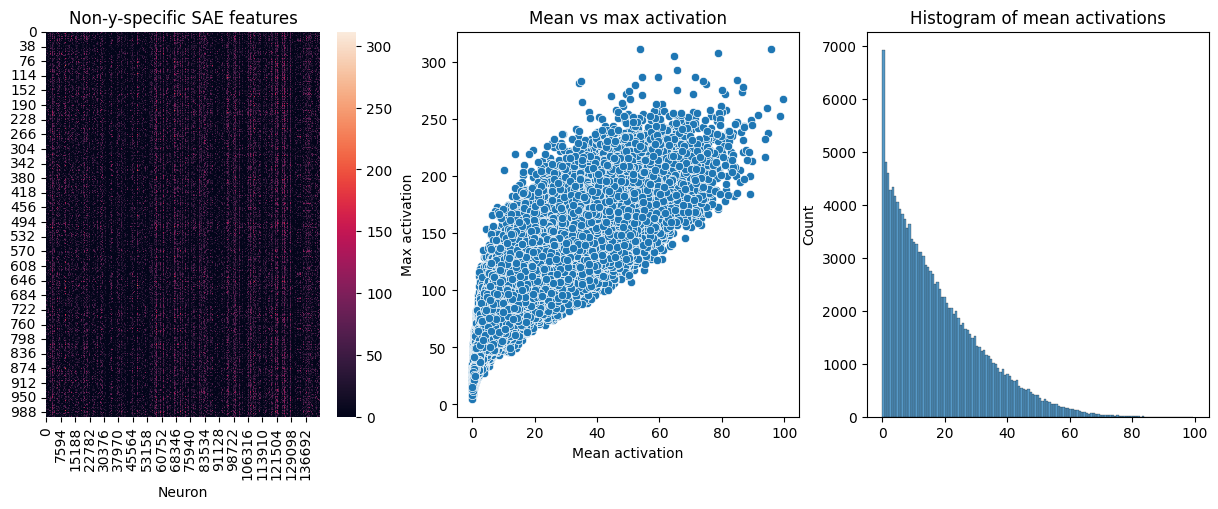

In [20]:
# plot their mean vs max activations

fig, ax = plt.subplots(1, 3, figsize=(15,5))
sns.heatmap(activations[:,non_y_sae_features].cpu().detach().numpy(), ax=ax[0])
ax[0].set_xlabel('Neuron')
ax[0].set_title('Non-y-specific SAE features')
# on the other size plot them averaged over ct
sns.scatterplot(x=activations[:,non_y_sae_features].mean(axis=0).cpu().detach().numpy(), y=activations[:,non_y_sae_features].max(axis=0).values.cpu().detach().numpy(), ax=ax[1])
ax[1].set_xlabel('Mean activation')
ax[1].set_ylabel('Max activation')
ax[1].set_title('Mean vs max activation')
# now a histogram of mean activations
sns.histplot(activations[:,non_y_sae_features].mean(axis=0).cpu().detach().numpy(), ax=ax[2])
ax[2].set_title('Histogram of mean activations')
plt.show()


(150000, 150)


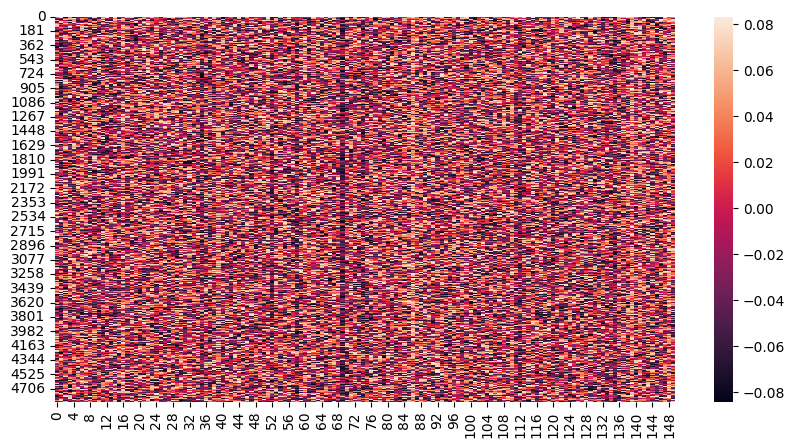

In [18]:
# look at the weights for the y-specific features

# get the weights
weights = sae_model.encoder_linear.weight.cpu().detach().numpy()
weights_y = weights[list(set(sae_feature_for_y)),:]

# plot a heatmap of the weights
fig, ax = plt.subplots(1, 1, figsize=(10,5))
sns.heatmap(weights_y, ax=ax)
plt.show()

In [ ]:
# build a graph of the non-redundant neurons
# edge weights should be the cosine similarities between the neurons
# node labels should be the variable with highest cosine similarity

# make a graph from cos_sim_sae

import networkx as nx
G = nx.Graph()

weight_threshold = 0.8

# make a node attribute dict
label_color_dict = {'y': 'blue', 'x0': 'red', 'x1': 'green', 'x2': 'yellow', 'ct': 'purple', 'co': 'orange'}
node_dict_y = {idx: {'label': coeff_names[int(max_cos_sim[i,1])], 'color': label_color_dict[coeff_names[int(max_cos_sim[i,1])]]} for i, idx in enumerate(list(unique_active_indices))}
node_dict_latent = {i: {'label': 'latent', 'color': 'black'} for i in range(activations.shape[1],weights.shape[1]+activations.shape[1])}
edge_tuples = []
for i, idx in enumerate(unique_active_indices):
    for j, jdx in enumerate(node_dict_latent.keys()):
        if weights[idx,j] > weight_threshold:
            edge_tuples.append((idx, jdx, weights[idx,j]))
# combine the node dicts
node_dict = {**node_dict_y, **node_dict_latent}

G.add_nodes_from(node_dict)
G.add_weighted_edges_from(edge_tuples)

print('Number of connected components: {}'.format(list(nx.connected_components(G))))

# remove all nodes that are not connected to any other node
G.remove_nodes_from(list(nx.isolates(G)))

# plot the graph
pos = nx.spring_layout(G)
#pos = nx.spectral_layout(G)
node_colors = [node_dict[node]['color'] for node in G.nodes()]
plt.figure(figsize=(10,10))
nx.draw(G, pos, with_labels=True, node_color=node_colors)
plt.show()

20302
149999


IndexError: index 131875 is out of bounds for dimension 0 with size 131875

In [22]:
len(coeff_names)

20302

In [32]:
max_cos_sim.shape

torch.Size([131875, 2])

In [ ]:
# build a graph of the non-redundant neurons
# edge weights should be the cosine similarities between the neurons
# node labels should be the variable with highest cosine similarity

# make a graph from cos_sim_sae

import networkx as nx
G = nx.Graph()

cos_sim_sae_threshold = 0.9

# make a node attribute dict
label_color_dict = {'y': 'blue', 'x0': 'red', 'x1': 'green', 'x2': 'yellow', 'ct': 'purple', 'co': 'orange'}
node_dict = {i: {'label': coeff_names[int(max_cos_sim[i,1])], 'color': label_color_dict[coeff_names[int(max_cos_sim[i,1])]]} for i in list(unique_active_indices)}
edge_tuples = [(idx, jdx, cos_sim_sae[idx,jdx].item()) for i, idx in enumerate(unique_active_indices) for j, jdx in enumerate(unique_active_indices) if ((i < j) and (cos_sim_sae[idx,jdx].item() > cos_sim_sae_threshold))]

G.add_nodes_from(node_dict)
G.add_weighted_edges_from(edge_tuples)

print('Number of connected components: {}'.format(list(nx.connected_components(G))))

# remove all nodes that are not connected to any other node
G.remove_nodes_from(list(nx.isolates(G)))

# plot the graph
pos = nx.spring_layout(G)
#pos = nx.spectral_layout(G)
node_colors = [node_dict[node]['color'] for node in G.nodes()]
plt.figure(figsize=(10,10))
nx.draw(G, pos, with_labels=True, node_color=node_colors)
plt.show()

### trying to identify x2 variables and xy

NameError: name 'cos_sim_sae' is not defined